In [1]:
# describe the data

# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.parse


# Wikispeedia dataset exploration

Let's begin by exploring the Wikispeedia dataset. The dataset is composed of six files:
- articles.tsv, which contains the list of wikipedia articles
- categories.tsv, which contains the list of wikipedia categories
- links.tsv, which contains the list of links between articles
- paths_finished.tsv, which contains the list of human paths finished by the users
- paths_unfinished.tsv, which contains the list of human paths unfinished by the users
- shortest-path-distance-matrix.txt, which contains the shortest path distance between each pair of articles

In [2]:
# Load all the data from the tsv files, skipping the headers and specifying column names
DATA_FOLDER = 'data/wikispeedia_paths-and-graph/'
articles = pd.read_csv(DATA_FOLDER + 'articles.tsv', sep='\t', skiprows=12, names=['article'])
categories = pd.read_csv(DATA_FOLDER + 'categories.tsv', sep='\t', skiprows=12, names=['article', 'category'])
links = pd.read_csv(DATA_FOLDER + 'links.tsv', sep='\t', skiprows=11, names=['linkSource', 'linkTarget'])
paths_finished = pd.read_csv(DATA_FOLDER + 'paths_finished.tsv', sep='\t', skiprows=15, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
paths_unfinished = pd.read_csv(DATA_FOLDER + 'paths_unfinished.tsv', sep='\t', skiprows=16, names=['hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'target', 'type'])

In [3]:
# Decode the URL-encoded article titles
articles = articles.map(urllib.parse.unquote)
categories = categories.map(urllib.parse.unquote)
links = links.map(urllib.parse.unquote)
paths_finished['path'] = paths_finished['path'].map(urllib.parse.unquote)
paths_unfinished['path'] = paths_unfinished['path'].map(urllib.parse.unquote)

### 1.a Articles 

Here, not much to describe, besides the number of articles.

In [4]:
# Count the articles
articles.count()

article    4604
dtype: int64

### 1.b Links

Let's play with the articles and links files to understand the structure of the dataset. On average, each article has 26 links to other articles. The United States article has the most outgoing (294) and incoming (1551) links. No article has no outgoing link nor is unreacheable.

In [8]:
# describe
print('-----Outgoing Links-----')
print(links['linkSource'].value_counts().describe())
print('-----Incoming Links-----')
print(links['linkTarget'].value_counts().describe())
links.describe()

-----Outgoing Links-----
count    4587.000000
mean       26.135165
std        24.194229
min         1.000000
25%        11.000000
50%        19.000000
75%        33.000000
max       294.000000
Name: count, dtype: float64
-----Incoming Links-----
count    4136.000000
mean       28.985010
std        65.554144
min         1.000000
25%         4.000000
50%        10.000000
75%        29.000000
max      1551.000000
Name: count, dtype: float64


,linkSource,linkTarget
count,119882,119882
unique,4587,4136
top,United_States,United_States
freq,294,1551


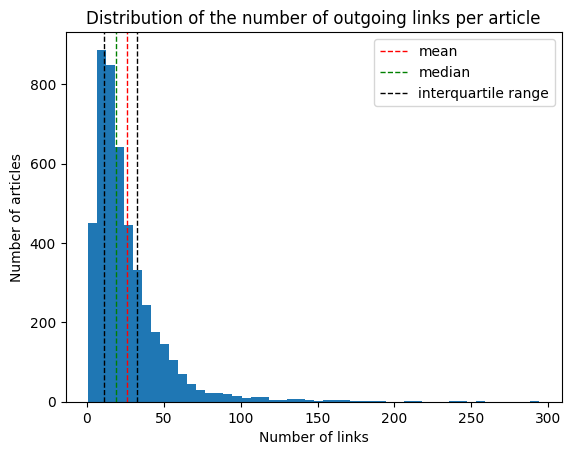

,linkTarget
count,4587.000000
mean,26.135165
std,24.194229
min,1.000000
25%,11.000000
50%,19.000000
75%,33.000000
max,294.000000


In [9]:

# plot the distribution of the number of links per article
links_per_article = links.groupby('linkSource').count()
links_per_article.hist(bins=50)
plt.title('Distribution of the number of outgoing links per article')
plt.xlabel('Number of links')
plt.ylabel('Number of articles')
# plot mean, median and interquartile range
plt.axvline(links_per_article.mean().values[0], color='r', linestyle='dashed', linewidth=1, label='mean')
plt.axvline(links_per_article.median().values[0], color='g', linestyle='dashed', linewidth=1, label='median')
plt.axvline(links_per_article.quantile(0.25).values[0], color='black', linestyle='dashed', linewidth=1)
plt.axvline(links_per_article.quantile(0.75).values[0], color='black', linestyle='dashed', linewidth=1, label='interquartile range')
plt.legend()
plt.grid(False)
plt.show()

# get the mean, median, min and max number, std of links per article
links_per_article.describe()


The distribution is highly skewed to the right, with most articles having a relatively small number of outgoing links. The mean (26.1) is higher than the median (19).

Let's now plot the distribution of incoming links.

In [108]:
# get the number of incoming links for each article
# create a list of all articles that are linked to the article
links = links.groupby('linkSource')['linkTarget'].apply(list).reset_index(name='links')
incoming_links = []
for index, row in links.iterrows():
    for link in row['links']:
        incoming_links.append(link)
incoming_links = pd.Series(incoming_links)

incoming_links = incoming_links.value_counts()
incoming_links = incoming_links.reset_index()
incoming_links.columns = ['article', 'incoming_number']

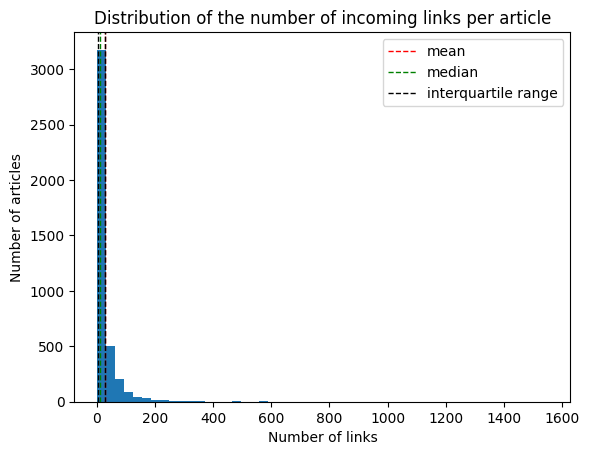

,incoming_number
count,4136.000000
mean,28.985010
std,65.554144
min,1.000000
25%,4.000000
50%,10.000000
75%,29.000000
max,1551.000000


In [109]:
incoming_links.hist(bins=50)
plt.title('Distribution of the number of incoming links per article')
plt.xlabel('Number of links')
plt.ylabel('Number of articles')
# plot mean, median and interquartile range
plt.axvline(incoming_links['incoming_number'].mean(), color='r', linestyle='dashed', linewidth=1, label='mean')
plt.axvline(incoming_links['incoming_number'].median(), color='g', linestyle='dashed', linewidth=1, label='median')
plt.axvline(incoming_links['incoming_number'].quantile(0.25), color='black', linestyle='dashed', linewidth=1)
plt.axvline(incoming_links['incoming_number'].quantile(0.75), color='black', linestyle='dashed', linewidth=1, label='interquartile range')
plt.legend()
plt.grid(False)
plt.show()

# get the mean, median, min and max number, std of incoming links per article
incoming_links.describe()

Here, the distribution is closer to smaller values. However, there are stronger outliers, the mean (29) is way higher than the median (10)

We now want to look at a graph representation of articles.

In [11]:
# creating a graph 
import networkx as nx

# Initialize directed graph
G = nx.DiGraph()
# creating a dataframe of edges
edges = links[['linkSource', 'linkTarget']]
# Add edges to the graph
G.add_edges_from(edges.values)  # Assuming edges is a DataFrame with columns [linksource, linktarget]

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


Graph has 4593 nodes and 119882 edges.


The lower number of articles than previously stated seems to indicate that some articles are not present in the links data, which might be due to being not reachable.

In [13]:
# Nodes with in-degree < 10 (median)
low_in_degree_nodes = [node for node, in_degree in G.in_degree() if in_degree < 10]

# Nodes with out-degree < 19 (median)
low_out_degree_nodes = [node for node, out_degree in G.out_degree() if out_degree < 19]

# Nodes with total degree < 30 (sum of both medians)
low_total_degree_nodes = [node for node, degree in G.degree() if degree < 30]

print("Nodes with in-degree less than the median (10):", low_in_degree_nodes)
print("Nodes with out-degree less than the median (19):", low_out_degree_nodes)
print("Nodes with total degree less than both medians (30):", low_total_degree_nodes)


Nodes with in-degree less than the median (10): ['Áedán_mac_Gabráin', 'Åland', 'Édouard_Manet', 'Absinthe', 'Diego_Velázquez', 'Francisco_Goya', 'Éire', 'Óengus_I_of_the_Picts', '€2_commemorative_coins', 'Cathedral_of_Magdeburg', 'Numismatics', 'Sanssouci', 'Great_Moravia', 'Leif_Ericson', 'Macbeth_of_Scotland', 'Norman_conquest_of_England', 'Angkor_Wat', 'Francis_of_Assisi', 'Second_Crusade', 'The_Anarchy', 'Abacus', "English_peasants'_revolt_of_1381", 'Ibn_Battuta', '15th_Marine_Expeditionary_Unit', 'Kuwait_City', 'Mogadishu', 'Mount_Pinatubo', 'Royal_Marines', 'Battle_of_Grunwald', 'Joan_of_Arc', 'Johannes_Ockeghem', 'Zheng_He', '16_Cygni', '16_Cygni_Bb', 'Ivan_IV_of_Russia', 'Jacques_Cartier', 'Juan_Sebastián_Elcano', 'Spanish_conquest_of_the_Inca_Empire', 'Suleiman_the_Magnificent', 'William_the_Silent', '1755_Lisbon_earthquake', 'Armand_Jean_du_Plessis,_Cardinal_Richelieu', 'Philosophiae_Naturalis_Principia_Mathematica', 'William_Harvey', '1896_Summer_Olympics', 'Catherine_II_of_

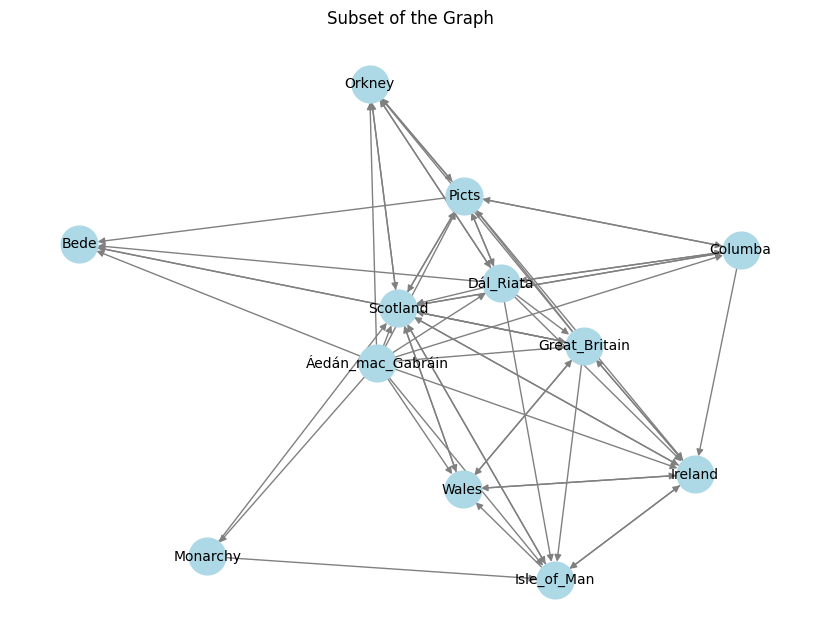

In [ ]:
# Get neighbors of a specific node (e.g., the first one in the list)
node_of_interest = low_total_degree_nodes[0]
neighbors = list(G.successors(node_of_interest)) + [node_of_interest]

# Create a subgraph from the selected nodes
subgraph = G.subgraph(neighbors)

# Draw the subgraph
plt.figure(figsize=(8, 6))
nx.draw(
    subgraph,
    with_labels=True,
    node_size=700,
    node_color="lightblue",
    font_size=10,
    edge_color="gray",
)
plt.title("Subset of the Graph")
plt.show()


In [112]:
# get the 5 articles with the highest in-degree
in_degrees = G.in_degree()

# Sort the articles by in-degree
sorted_in_degrees = sorted(in_degrees, key=lambda x: x[1], reverse=True)

# Get the top 5 articles with the highest in-degree
top_5_in_degrees = sorted_in_degrees[:5]

# Print the top 5 articles with the highest in-degree
for article, in_degree in top_5_in_degrees:
    print(f"Article: {article}, In-degree: {in_degree}")

Article: United_States, In-degree: 1551
Article: United_Kingdom, In-degree: 972
Article: France, In-degree: 959
Article: Europe, In-degree: 933
Article: World_War_II, In-degree: 751


In [113]:
# get the 5 articles with the highest out-degree
out_degrees = G.out_degree()

# Sort the articles by out-degree
sorted_out_degrees = sorted(out_degrees, key=lambda x: x[1], reverse=True)

# Get the top 5 articles with the highest out-degree
top_5_out_degrees = sorted_out_degrees[:5]

# Print the top 5 articles with the highest out-degree
for article, out_degree in top_5_out_degrees:
    print(f"Article: {article}, Out-degree: {out_degree}")

Article: United_States, Out-degree: 294
Article: Driving_on_the_left_or_right, Out-degree: 255
Article: List_of_countries, Out-degree: 244
Article: List_of_circulating_currencies, Out-degree: 236
Article: List_of_sovereign_states, Out-degree: 216


### 1.c Categories

We also have access to the categories of the articles. Each article belongs to one or more categories. There is 129 different categories. Articles have at most 3 categories. The average number of categories per article is 1.1.

In [16]:
categories.describe()

,article,category
count,5204,5204
unique,4598,129
top,Pottery,subject.Countries
freq,3,229


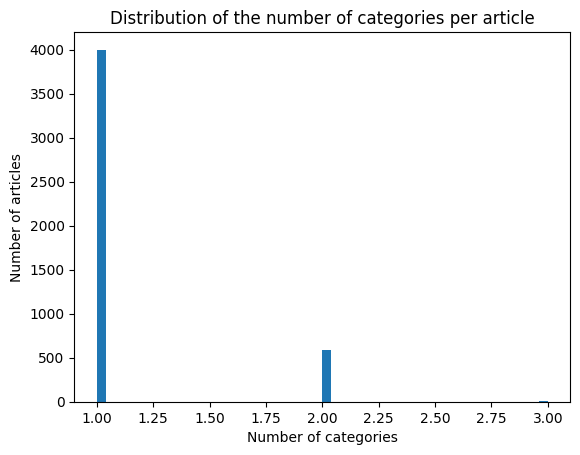

In [17]:
# plot the distribution of the number of categories per article
categories_per_article = categories.groupby('article').count()
categories_per_article.hist(bins=50)
plt.title('Distribution of the number of categories per article')
plt.xlabel('Number of categories')
plt.ylabel('Number of articles')
plt.grid(False)
plt.show()

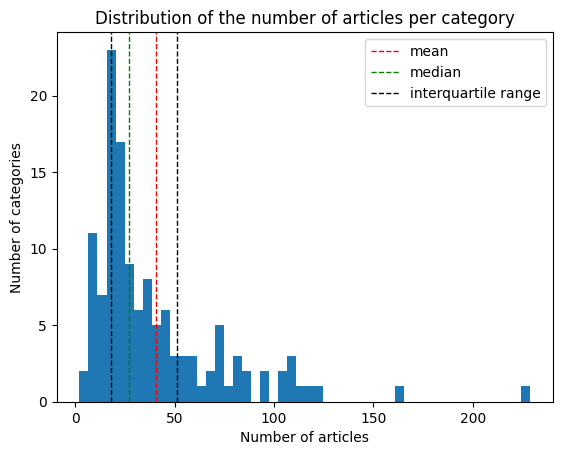

,article
count,129.000000
mean,40.341085
std,34.678095
min,2.000000
25%,18.000000
50%,27.000000
75%,51.000000
max,229.000000


In [116]:
# plot the distribution of the number of articles per category
articles_per_category = categories.groupby('category').count()
articles_per_category.hist(bins=50)
plt.title('Distribution of the number of articles per category')
plt.xlabel('Number of articles')
plt.ylabel('Number of categories')
plt.grid(False)

# plot mean, median and interquartile range
plt.axvline(articles_per_category.mean().values[0], color='r', linestyle='dashed', linewidth=1, label='mean')
plt.axvline(articles_per_category.median().values[0], color='g', linestyle='dashed', linewidth=1, label='median')
plt.axvline(articles_per_category.quantile(0.25).values[0], color='black', linestyle='dashed', linewidth=1)
plt.axvline(articles_per_category.quantile(0.75).values[0], color='black', linestyle='dashed', linewidth=1, label='interquartile range')
plt.legend()
plt.show()

articles_per_category.describe()

Here, we can clearly see that categories are not at all evenly distributed amongst the dataset, this might be useful in later analysis.

### 1.d Paths Finished

We have access to a lot of paths! There are 51318 finished paths. However, the same path was completed many times, we are more interested in unique paths. We hence processed the data so that it only contain a given pair of start and goal articles at most once (chosen at random). This gives us a total of 28718 unique paths. 

In [18]:
paths_finished.describe()

,timestamp,durationInSec,rating
count,5.131800e+04,51318.000000,28501.000000
mean,1.296384e+09,158.276199,2.269780
std,4.935086e+07,360.841904,1.110439
min,1.219095e+09,0.000000,1.000000
25%,1.250109e+09,60.000000,1.000000
50%,1.283894e+09,107.000000,2.000000
75%,1.345231e+09,183.000000,3.000000
max,1.389823e+09,35091.000000,5.000000


In [118]:
# get the number of unique path finished using unique path_id
paths_finished = pd.read_csv('data/paths_finished_unique.tsv', sep='\t', skiprows=1, names=['path_id', 'hashedIpAddress', 'timestamp', 'durationInSec', 'path', 'rating'])
print('Number of rows in paths_finished:', paths_finished.shape[0])

Number of rows in paths_finished: 28718


The average path length is 5.7 steps. The shortest path is 0 steps long (which indicate that the player started on the goal article) and the longest is 434 steps. The player was probably bored at this point. 

count    51318.000000
mean         5.757434
std          4.680718
min          0.000000
25%          4.000000
50%          5.000000
75%          7.000000
max        434.000000
Name: path_length, dtype: float64

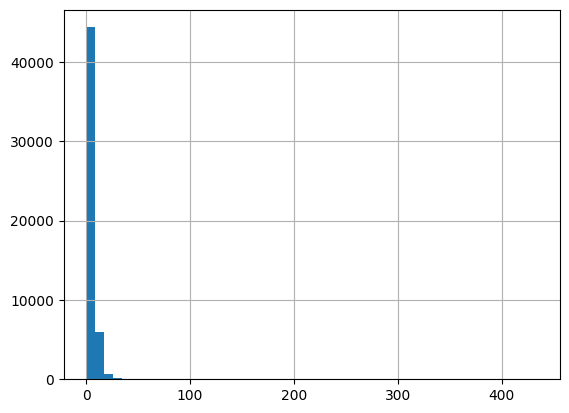

In [19]:
# get the number of steps in the finished paths
paths_finished['path_length'] = paths_finished['path'].apply(lambda x: len(x.split(';')) - 1)
paths_finished['path_length'].hist(bins=50)
paths_finished['path_length'].describe()

In [120]:
# get the paths with the longest path length
longest_paths = paths_finished.sort_values(by='path_length', ascending=False)
# get the pair of start and end articles
longest_paths['start'] = longest_paths['path'].apply(lambda x: x.split(';')[0])
longest_paths['end'] = longest_paths['path'].apply(lambda x: x.split(';')[-1])
# get the top 5 longest paths
longest_paths.head()


,path_id,hashedIpAddress,timestamp,durationInSec,path,rating,path_length,start,end
26842,26842,7f6da01d55086766,1248928447,2205,United_States;Washington%2C_D.C.;Government;Co...,5.0,434,United_States,English_language
18090,18090,4f1b9ce764349901,1236685130,2292,Napoleon_I_of_France;United_Kingdom;Great_Brit...,NaN,118,Napoleon_I_of_France,Recycling
20612,20612,4e97d9af4476607f,1248925083,1141,Police_state;Police;United_States;Washington%2...,5.0,103,Police_state,African_slave_trade
15060,15060,0d57c8c57d75e2f5,1290096241,1852,Lake_Toba;Netherlands;Europe;Earth;United_Stat...,5.0,98,Lake_Toba,Looney_Tunes
7495,7495,6616bb9562890cb9,1222830740,971,David_Beckham;Munich;Onion_dome;Onion;Plant;He...,4.0,85,David_Beckham,Sorrel


Funny to see that the longest path was between two seemingly close notions: US and English language

In [121]:
print(paths_finished.head())

   path_id   hashedIpAddress   timestamp  durationInSec  \
0        0  651ff0fa4fac4471  1227628729             15   
1        1  516b61133d358ce1  1224623308              6   
2        2  32652d6d1c5d9351  1260397548             48   
3        3  0d57c8c57d75e2f5  1296192247             15   
4        4  40111bc7370e59f5  1250228731             92   

                                                path  rating  path_length  
0   %E2%82%AC2_commemorative_coins;Ireland;Irish_Sea     1.0            2  
1                          10th_century;11th_century     1.0            1  
2  10th_century;Maya_civilization;Silver;Coin;Ban...     3.0            4  
3                       10th_century;Germany;Country     1.0            2  
4  10th_century;France;United_States;Basketball;H...     2.0            4  


Do people take a long time to finish the game? The average time is 161 seconds, i.e., 2min 40 s. The longest time is 35091 s, that is 9h 58min 21s. The shortest time is 0 s, i.e., the player was immediately done. Most of the players (75th percentile) took less than 3 minutes, 3 seconds to finish the game.

In [21]:
paths_finished['durationInSec'].describe()


count    51318.000000
mean       158.276199
std        360.841904
min          0.000000
25%         60.000000
50%        107.000000
75%        183.000000
max      35091.000000
Name: durationInSec, dtype: float64

In [22]:
# get the path with the longest duration
longest_duration = paths_finished.sort_values(by='durationInSec', ascending=False)
longest_duration.head()
# print the path with the longest duration
print('Longest duration path:', longest_duration.iloc[0])

Longest duration path: hashedIpAddress                                     3c623ddc539a389a
timestamp                                                 1262371920
durationInSec                                                  35091
path               Norse_mythology;Literature;Fiction;Computer_an...
rating                                                           NaN
path_length                                                        7
Name: 10855, dtype: object


The longest path in time duration is not even the longest one in path_length!

Let's look at the shortest durations now

In [124]:
shortest_duration = paths_finished.sort_values(by='durationInSec', ascending=True)
shortest_duration.head()
# print the path with the longest duration
print('Shortest duration path:', shortest_duration.iloc[0])

Shortest duration path: path_id                       28186
hashedIpAddress    43f864c75b2571b5
timestamp                1350587414
durationInSec                     0
path               William_and_Mary
rating                          NaN
path_length                       0
Name: 28186, dtype: object


This seems like an example of the player arriving directly at its destination

We now look at the number of steps in the finished paths and the duration in seconds, to look if we can see similarities or correlations.

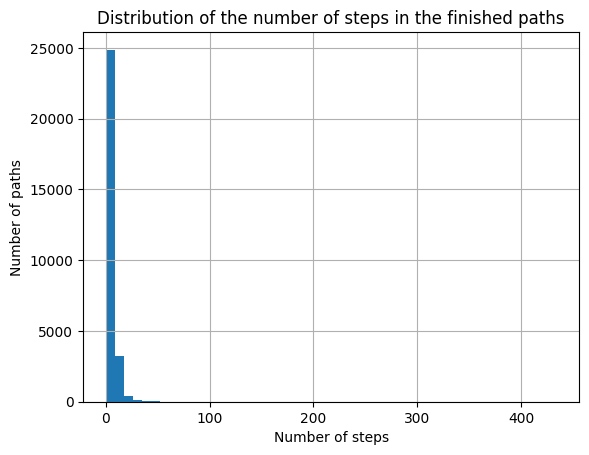

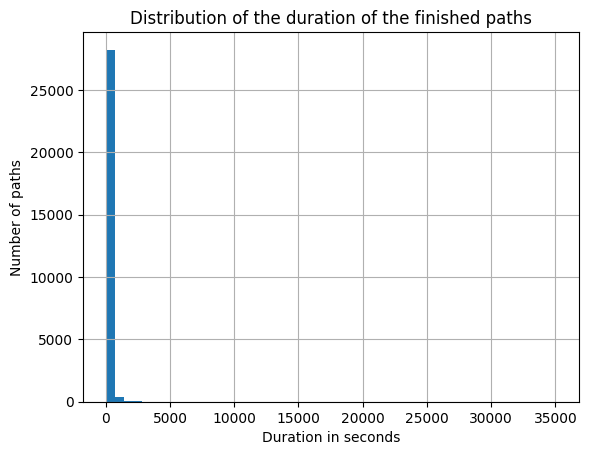

In [125]:
# plot the distribution of the number of steps in the finished paths
paths_finished['path_length'].hist(bins=50)
plt.title('Distribution of the number of steps in the finished paths')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.show()

# plot the distribution of the duration of the finished paths
paths_finished['durationInSec'].hist(bins=50)
plt.title('Distribution of the duration of the finished paths')
plt.xlabel('Duration in seconds')
plt.ylabel('Number of paths')
plt.show()




Not going further into the duration exploration, as it will not be necessary for our story.

Let's look at the distribution of steps, we look at less than the 98th percentile to dismiss outliers.

In [23]:
# get the 98th percentile of the number of steps in the finished paths
paths_finished['path_length'].quantile(0.98)

17.0

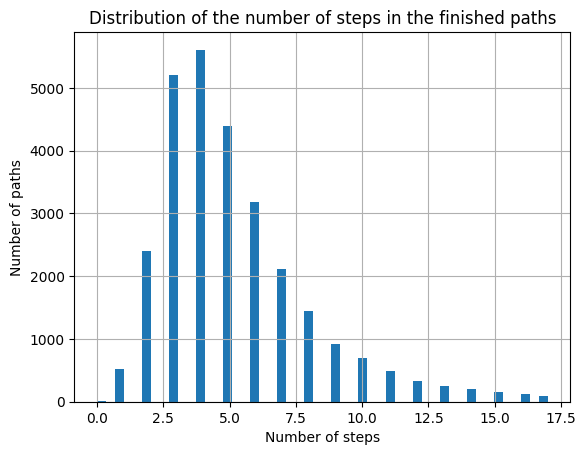

In [138]:
# drop the rows with number of steps > 18
paths_finished_lt_18 = paths_finished[paths_finished['path_length'] < 17]

# plot the distribution of the number of steps in the finished paths
paths_finished_lt_18['path_length'].hist(bins=50)
plt.title('Distribution of the number of steps in the finished paths')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.show()

Let's now look at the ratings! It is not mandatory to give a rating. 

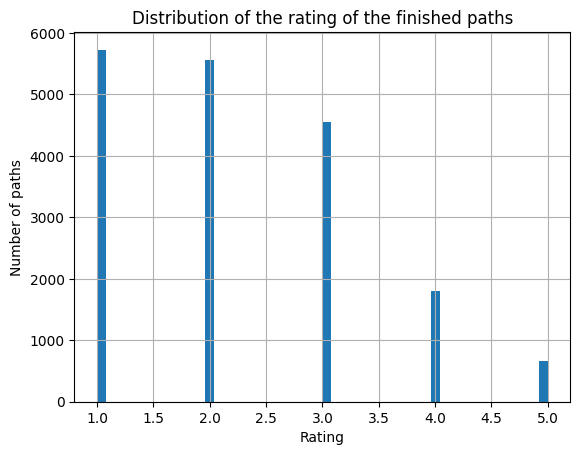

In [139]:
# plot the distribution of the rating of the finished paths
paths_finished['rating'].hist(bins=50)
plt.title('Distribution of the rating of the finished paths')
plt.xlabel('Rating')
plt.ylabel('Number of paths')
plt.show()

In [140]:
# for each row add a column containing the pair of the first and last article in the path
paths_finished['pair'] = paths_finished['path'].apply(lambda x: x.split(';')[0] + ' -> ' + x.split(';')[-1])

print(paths_finished.head())

   path_id   hashedIpAddress   timestamp  durationInSec  \
0        0  651ff0fa4fac4471  1227628729             15   
1        1  516b61133d358ce1  1224623308              6   
2        2  32652d6d1c5d9351  1260397548             48   
3        3  0d57c8c57d75e2f5  1296192247             15   
4        4  40111bc7370e59f5  1250228731             92   

                                                path  rating  path_length  \
0   %E2%82%AC2_commemorative_coins;Ireland;Irish_Sea     1.0            2   
1                          10th_century;11th_century     1.0            1   
2  10th_century;Maya_civilization;Silver;Coin;Ban...     3.0            4   
3                       10th_century;Germany;Country     1.0            2   
4  10th_century;France;United_States;Basketball;H...     2.0            4   

                                          pair  
0  %E2%82%AC2_commemorative_coins -> Irish_Sea  
1                 10th_century -> 11th_century  
2                     10th_century 

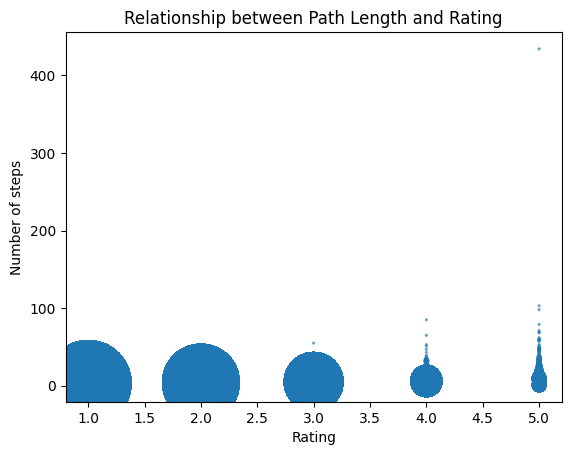

In [166]:
# Calculate the path length for each finished path
paths_finished_with_ratings = paths_finished.dropna(subset=['rating'])
point_sizes = paths_finished_with_ratings.groupby(['rating', 'path_length']).size().reset_index(name='counts')
merged_data = pd.merge(paths_finished_with_ratings, point_sizes, on=['rating', 'path_length'])
# Plot the relationship between rating and path length as a bar plot with inverted axes
plt.scatter(merged_data['rating'], merged_data['path_length'], s=merged_data['counts']*2, alpha=0.5)
plt.ylabel('Number of steps')
plt.xlabel('Rating')
plt.title('Relationship between Path Length and Rating')
plt.show()

In [134]:
# Compute the correlation between rating and path length using scipy
from scipy.stats import pearsonr, spearmanr

# Calculate the Pearson correlation coefficient and its p-value
pearson_corr, pearson_p_value = pearsonr(paths_finished_with_ratings['rating'], paths_finished_with_ratings['path_length'])
print(f"Pearson Correlation Coefficient: {pearson_corr}, p-value: {pearson_p_value}")

# Calculate the Spearman correlation
spearman_corr, spearman_p_value = spearmanr(paths_finished_with_ratings['rating'], paths_finished_with_ratings['path_length'])
print(f"Spearman Correlation Coefficient: {spearman_corr}, p-value: {spearman_p_value}")


Pearson Correlation Coefficient: 0.41156854924009395, p-value: 0.0
Spearman Correlation Coefficient: 0.5918271303966154, p-value: 0.0


In [158]:
# same correlation computation but discarding outliers (paths under the 80th percentile)
q80 = paths_finished['path_length'].quantile(0.8)
paths_finished_under80_with_ratings = paths_finished[paths_finished['path_length'] < q80].dropna(subset=['rating'])
pearson_corr, pearson_p_value = pearsonr(paths_finished_under80_with_ratings['rating'], paths_finished_under80_with_ratings['path_length'])
print(f"Pearson Correlation Coefficient (without outliers): {pearson_corr}, p-value: {pearson_p_value}")
spearman_corr, spearman_p_value = spearmanr(paths_finished_under80_with_ratings['rating'], paths_finished_under80_with_ratings['path_length'])
print(f"Spearman Correlation Coefficient (without outliers): {spearman_corr}, p-value: {spearman_p_value}")


Pearson Correlation Coefficient (without outliers): 0.41903827049101117, p-value: 0.0
Spearman Correlation Coefficient (without outliers): 0.46947593405371385, p-value: 0.0


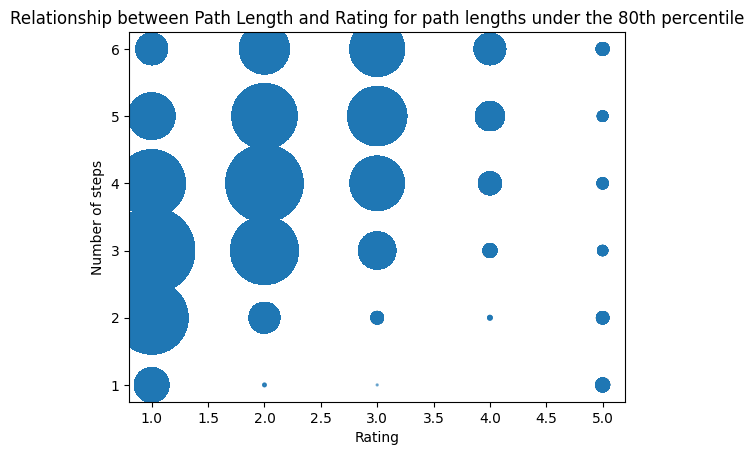

In [ ]:
# Calculate the size of the points based on the number of occurrences
point_sizes = paths_finished_under80_with_ratings.groupby(['rating', 'path_length']).size().reset_index(name='counts')
merged_data = pd.merge(paths_finished_under80_with_ratings, point_sizes, on=['rating', 'path_length'])

plt.scatter(merged_data['rating'], merged_data['path_length'], s=merged_data['counts']*2, alpha=0.5)
plt.ylabel('Number of steps')
plt.xlabel('Rating')
plt.title('Relationship between Path Length and Rating for path lengths under the 80th percentile')
plt.show()

### 1.e Paths Unfinished

For different reasons, some people did not finish the game. There are 24875 unfinished paths. The average path length is 6,75. 

In [167]:
paths_unfinished.describe()

,timestamp,durationInSec
count,2.487500e+04,24875.000000
mean,1.344763e+09,835.296884
std,2.772317e+07,881.287961
min,1.297055e+09,4.000000
25%,1.320339e+09,86.000000
50%,1.348587e+09,261.000000
75%,1.367373e+09,1831.000000
max,1.389823e+09,9089.000000


In [168]:
# for each row add a column containing the pair of the first article in the path and the target article
paths_unfinished['pair'] = paths_unfinished['path'].apply(lambda x: x.split(';')[0]) + ' -> ' + paths_unfinished['target']

print(paths_unfinished.head())

    hashedIpAddress   timestamp  durationInSec  \
0  2426091a53125110  1297054935           1804   
1  26141fd878806294  1297055651           1805   
2  2b015fb8181c48f2  1297090819           1818   
3  53a53bc244e08a6a  1297094761             49   
4  53a53bc244e08a6a  1297099105           1808   

                                   path            target     type  \
0                        Obi-Wan_Kenobi         Microsoft  timeout   
1                         Julius_Caesar           Caracas  timeout   
2  Malawi;Democracy;Alexander_the_Great     First_Crusade  timeout   
3                              Paraguay  Mount_St._Helens  restart   
4                      Paraguay;Bolivia  Mount_St._Helens  timeout   

                           pair  
0   Obi-Wan_Kenobi -> Microsoft  
1      Julius_Caesar -> Caracas  
2       Malawi -> First_Crusade  
3  Paraguay -> Mount_St._Helens  
4  Paraguay -> Mount_St._Helens  


In [169]:
# get the number of unique path unfinished using unique path_id
paths_unfinished_unique = paths_unfinished.drop_duplicates(subset='pair')

print('Number of rows in paths_unfinished:', paths_unfinished_unique.shape[0])

Number of rows in paths_unfinished: 18190


Let's look at some paths that some users finished and some that they did not finish. There are 13866 common paths between the finished and unfinished paths. 

In [170]:
# compare the finished pairs with the unfinished pairs and get the number of common pairs
common_pairs = paths_finished['pair'].isin(paths_unfinished['pair'])

print(common_pairs.sum())

4199


It's interesting to see that the average rating of the common pair is 2,63. It's higher than the average rating of the finished paths (2,20). We can see that the shape of the distribution of the ratings is decreasing for the finished paths but increasing between 1 and 3 for the unfinished paths then decreasing.

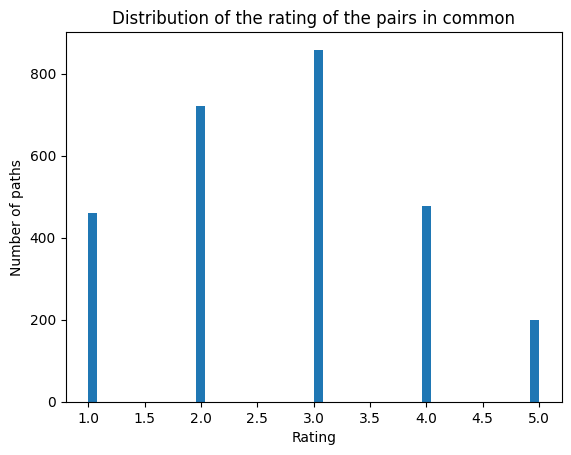

In [171]:
# get the distribution of the rating of the common pairs

common_pairs_rating = paths_finished[paths_finished['pair'].isin(paths_unfinished['pair'])]['rating']
common_pairs_rating.hist(bins=50)
plt.title('Distribution of the rating of the pairs in common')
plt.xlabel('Rating')
plt.ylabel('Number of paths')
plt.grid(False)
plt.show()


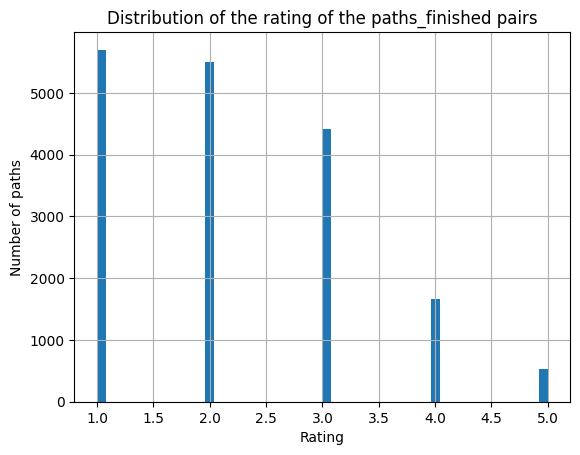

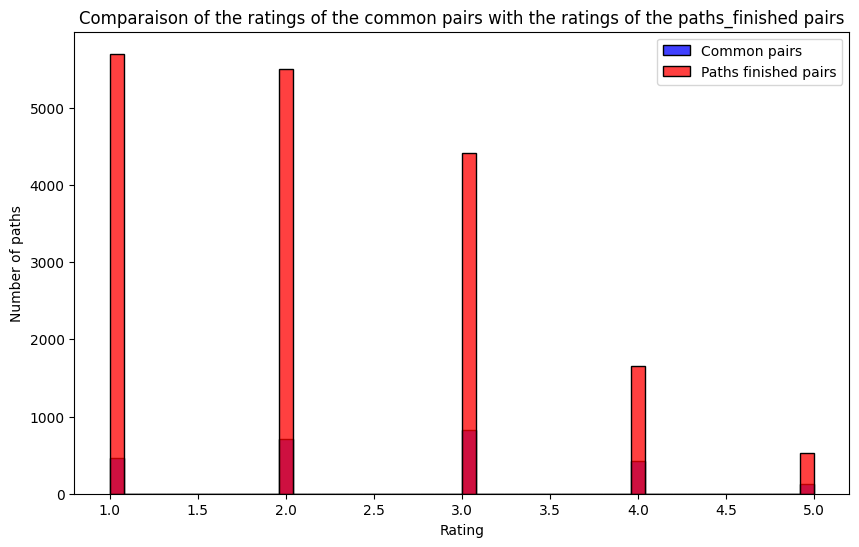

In [161]:
# get the distribution of the rating of the paths_finished pairs
paths_finished_rating = paths_finished['rating']
paths_finished_rating.hist(bins=50)
plt.title('Distribution of the rating of the paths_finished pairs')
plt.xlabel('Rating')
plt.ylabel('Number of paths')
plt.show()

# plot the comparaison the ratings of the common pairs with the ratings of the paths_finished pairs
plt.figure(figsize=(10, 6))
sns.histplot(common_pairs_rating, bins=50, color='blue', label='Common pairs')
sns.histplot(paths_finished_rating, bins=50, color='red', label='Paths finished pairs')
plt.title('Comparaison of the ratings of the common pairs with the ratings of the paths_finished pairs')
plt.xlabel('Rating')
plt.ylabel('Number of paths')
plt.legend()
plt.show()

In [162]:
common_pairs_rating.describe()

count    2542.000000
mean        2.630606
std         1.109534
min         1.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         5.000000
Name: rating, dtype: float64

In [163]:
paths_finished_rating.describe()

count    17791.000000
mean         2.201844
std          1.078957
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: rating, dtype: float64

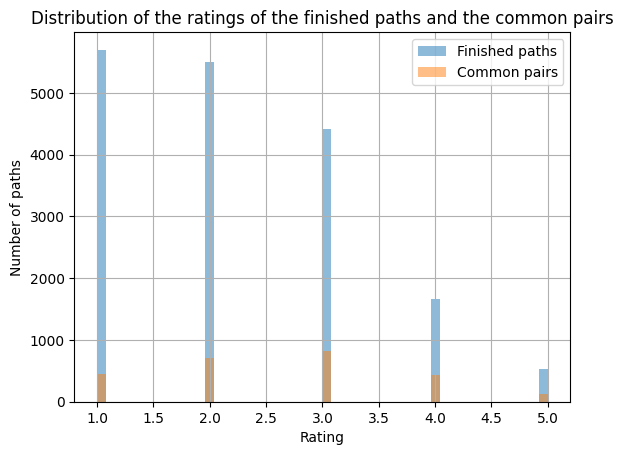

In [164]:
# compare the distribution of the ratings of the finished paths and the common pairs normalized by the number of paths
paths_finished['rating'].hist(bins=50, alpha=0.5, label='Finished paths')
common_pairs_rating.hist(bins=50, alpha=0.5, label='Common pairs')
plt.title('Distribution of the ratings of the finished paths and the common pairs')
plt.xlabel('Rating')
plt.ylabel('Number of paths')
plt.legend()
plt.show()


Look at the distribution of the duration of the unfinished paths. It seems that we have 2 plots. The first one corresponds to the duration less than 30min. The second one corresponds to the duration greater than 30min. The first correspond to the paths that end with a restard and the second one to the paths that end with a give up or timeout.

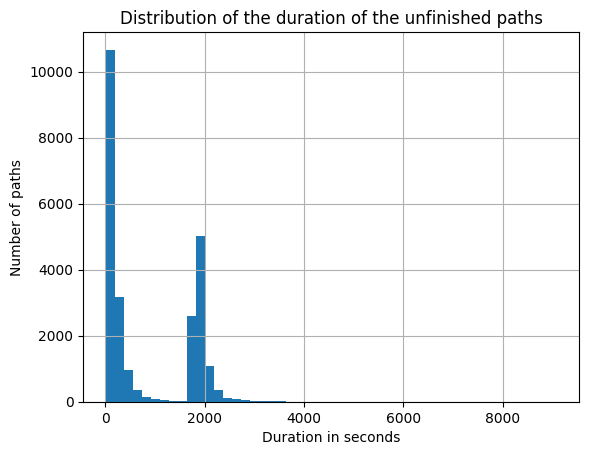

In [165]:
# plot the distribution of the duration of the unfinished paths
paths_unfinished['durationInSec'].hist(bins=50)
plt.title('Distribution of the duration of the unfinished paths')
plt.xlabel('Duration in seconds')
plt.ylabel('Number of paths')
plt.show()

In [166]:
# get the 98th percentile of the duration of the unfinished paths
paths_unfinished['durationInSec'].quantile(0.98)

np.float64(2262.0)

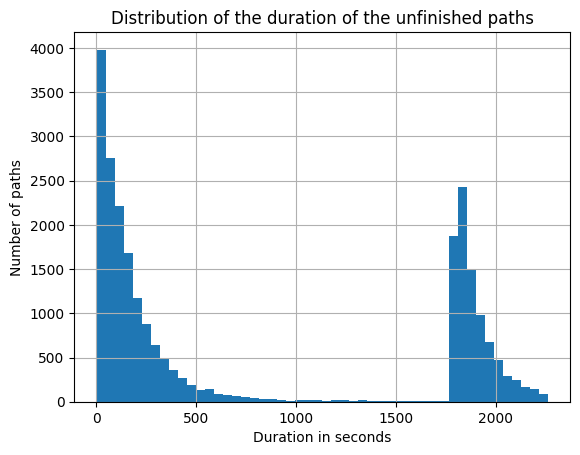

In [167]:
# drop the rows with durationInSec > 2262
paths_unfinished = paths_unfinished[paths_unfinished['durationInSec'] < 2262]

# plot the distribution of the duration of the unfinished paths
paths_unfinished['durationInSec'].hist(bins=50)
plt.title('Distribution of the duration of the unfinished paths')
plt.xlabel('Duration in seconds')
plt.ylabel('Number of paths')
plt.show()

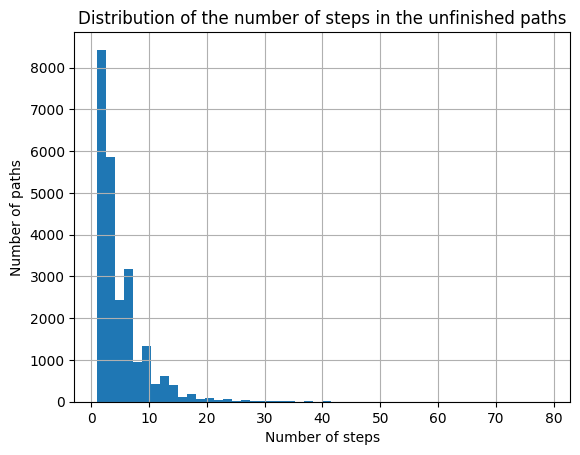

In [168]:
# plot the distribution of the number of steps in the unfinished paths
paths_unfinished['path_length'] = paths_unfinished['path'].apply(lambda x: len(x.split(';')))
paths_unfinished['path_length'].hist(bins=50)
plt.title('Distribution of the number of steps in the unfinished paths')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.show()

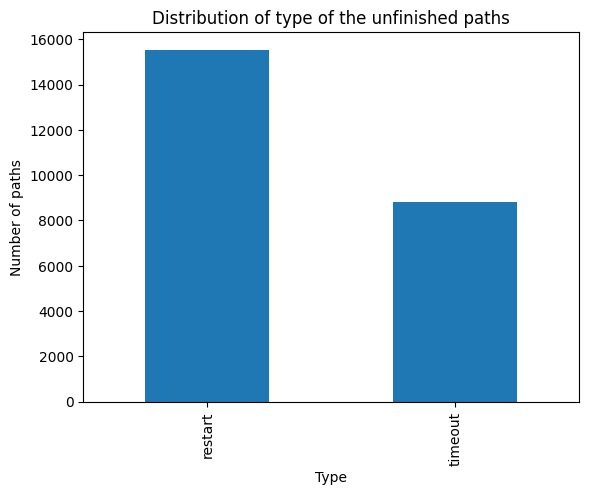

In [169]:
# plot the distribution of type of the unfinished paths
paths_unfinished['type'].value_counts().plot(kind='bar')
plt.title('Distribution of type of the unfinished paths')
plt.xlabel('Type')
plt.ylabel('Number of paths')
plt.show()

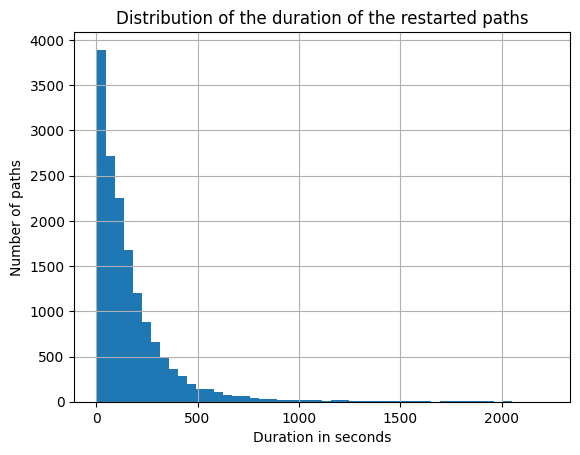

In [170]:
# plot the distribution of the duration of the restarted paths
paths_unfinished[paths_unfinished['type'] == 'restart']['durationInSec'].hist(bins=50)
plt.title('Distribution of the duration of the restarted paths')
plt.xlabel('Duration in seconds')
plt.ylabel('Number of paths')
plt.show()

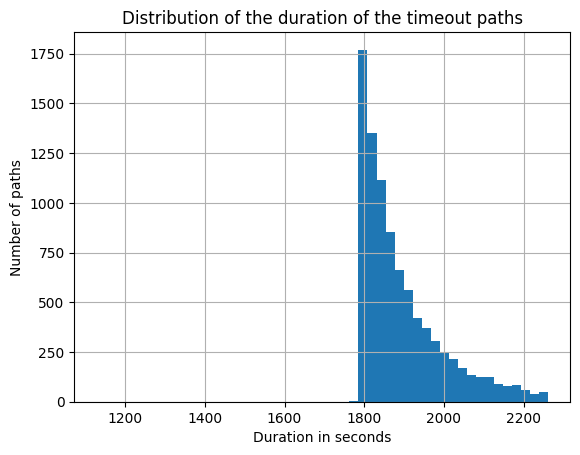

In [171]:
# plot the distribution of the duration of the timeout paths
paths_unfinished[paths_unfinished['type'] == 'timeout']['durationInSec'].hist(bins=50)
plt.title('Distribution of the duration of the timeout paths')
plt.xlabel('Duration in seconds')
plt.ylabel('Number of paths')
plt.show()


On average, the paths that end with a restart have a lower number of steps that the timeout. We cannot conclude anything particular about that because there are different reasons why a player restarts or timeout the game.

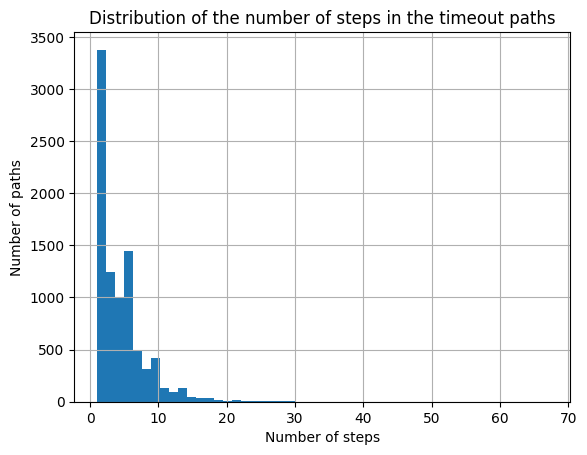

In [172]:
# plot the distribution of the number of steps in the timeout paths
paths_unfinished[paths_unfinished['type'] == 'timeout']['path_length'].hist(bins=50)
plt.title('Distribution of the number of steps in the timeout paths')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.show()

In [173]:
# get the 98th percentile of the number of steps in the timeout paths
paths_unfinished[paths_unfinished['type'] == 'timeout']['path_length'].quantile(0.98)

np.float64(15.0)

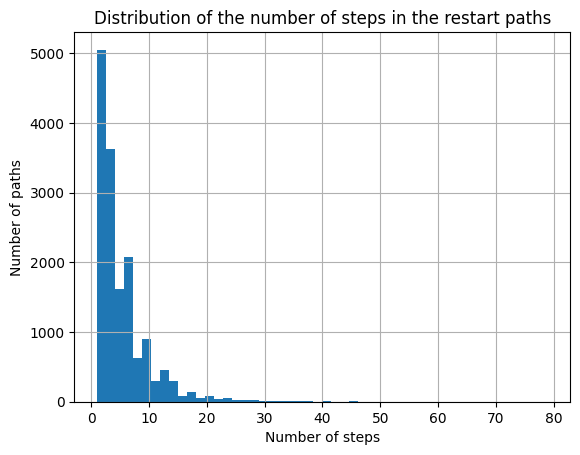

In [174]:
# plot the distribution of the number of steps of restart paths
paths_unfinished[paths_unfinished['type'] == 'restart']['path_length'].hist(bins=50)
plt.title('Distribution of the number of steps in the restart paths')
plt.xlabel('Number of steps')
plt.ylabel('Number of paths')
plt.show()

In [175]:
# get the 98th percentile of the number of steps in the restart paths
paths_unfinished[paths_unfinished['type'] == 'restart']['path_length'].quantile(0.98)

np.float64(20.0)

In [178]:
# describe the data
paths_unfinished[paths_unfinished['type'] == 'restart']['path_length'].describe()

count    15546.000000
mean         5.227904
std          5.079880
min          1.000000
25%          2.000000
50%          4.000000
75%          7.000000
max         79.000000
Name: path_length, dtype: float64

In [179]:
paths_unfinished[paths_unfinished['type'] == 'timeout']['path_length'].describe()

count    8830.000000
mean        4.344281
std         3.802274
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        67.000000
Name: path_length, dtype: float64